# Test Set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### Read raw test data

In [2]:
amazon = pd.read_csv('../amazon_data/raw_data_test.csv')
print(amazon.shape)

(91000, 14)


In [3]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      135712        475733  475734  B000RI8CU0  A37TA115S10WZU   
1       79135        279243  279244  B00020V5NO  A3B7M0C5RAD1CV   
2      321927        233021  233022  B001NZUJ2A  A1RY171OVII8ZS   
3      190767        514155  514156  B000QAA0WM   AIC1JXVTI5UFI   
4      181359        206960  206961  B004E2KIVG   AZAQH32M8DHDI   

                    ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
0                   F. M. Green                     0                       0   
1                        Justin                     3                       3   
2  Lauren K. Jonik "wildflowyr"                     0                       0   
3                         Diana                     1                       5   
4                         Coach                     0                       0   

   Score        Time                           Summary  \
0      5  1274054400                  WOW! Kitty Cra

### Feature extraction on natural language data

In [ ]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [4]:
# vectorize Bag of Words from review text; as sparse matrix
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
hv = joblib.load('hv.pkl')
X_hv = hv.transform(amazon.Text)
print(X_hv.shape)

/Users/aaronhill/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(91000, 131072)


In [5]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [6]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [7]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      5        620
1      5        157
2      5        186
3      1         82
4      4        185
5      5        586
6      5        541
7      3        125
8      4        138
9      5       3985
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [8]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 131074)


### Create `X`, scaled matrix of features

In [9]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

(91000, 131074)


### create `y`, vector of Labels

In [10]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

In [11]:
# MODEL: SVM, linear
# from sklearn import linear_model
# svm = linear_model.SGDClassifier()
# svm.fit(X, y)
# joblib.dump(svm, 'svm.pkl') # pickle
svm = joblib.load('svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'Pos': 6653, 'Neg': 84347, 'TP': 1625, 'TN': 79307, 'FP': 5040, 'FN': 5028, 'Accuracy': 0.88936263736263732, 'Precision': 0.24381095273818454, 'Recall': 0.24425071396362544, 'desc': 'svm'}


In [12]:
# MODEL: logistic regression
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
# lgs.fit(X, y)
# joblib.dump(lgs, 'lgs.pkl') # pickle
lgs = joblib.load('lgs.pkl')

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'Pos': 6653, 'Neg': 84347, 'TP': 1871, 'TN': 78799, 'FP': 5548, 'FN': 4782, 'Accuracy': 0.88648351648351653, 'Precision': 0.25219032214584175, 'Recall': 0.28122651435442658, 'desc': 'lgs'}


In [13]:
# MODEL: Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X, y)
# joblib.dump(nbs, 'nbs.pkl') # pickle
nbs = joblib.load('nbs.pkl')

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 6653, 'Neg': 84347, 'TP': 2646, 'TN': 71963, 'FP': 12384, 'FN': 4007, 'Accuracy': 0.81987912087912085, 'Precision': 0.17604790419161676, 'Recall': 0.39771531639861718, 'desc': 'nbs'}


In [14]:
# MODEL: Ridge Regression Classifier
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X, y)
# joblib.dump(rdg, 'rdg.pkl') # pickle
rdg = joblib.load('rdg.pkl')

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 6653, 'Neg': 84347, 'TP': 990, 'TN': 82920, 'FP': 1427, 'FN': 5663, 'Accuracy': 0.92208791208791208, 'Precision': 0.40959867604468347, 'Recall': 0.14880505035322411, 'desc': 'rdg'}


In [15]:
# MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle
prc = joblib.load('prc.pkl')

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

{'Pos': 6653, 'Neg': 84347, 'TP': 1642, 'TN': 78953, 'FP': 5394, 'FN': 5011, 'Accuracy': 0.88565934065934071, 'Precision': 0.23337123365548607, 'Recall': 0.24680595220201412, 'desc': 'prc'}


### ROC plot to compare performance of various models and fits

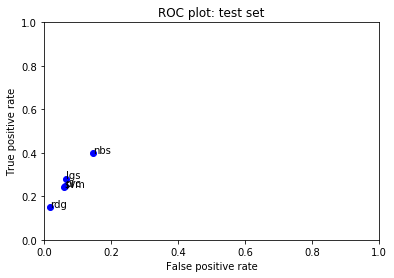

In [16]:
fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()